# Прогнозирование оттока клиентов сети фитнес-клубов

## Содержание
1. [Описание проекта](#step1)
2. [Исследовательский анализ данных](#step2)  
3. [Построение модели прогнозирования оттока клиентов](#step3)
4. [Кластеризация клиентов](#step4)
5. [Общий вывод](#step5)

<a id='step1'></a>
## 1. Описание проекта

**Задача:**   
- спрогнозировать вероятность оттока клиентов на уровне следующего месяца;  
- сформировать типичные портреты клиентов;  
- проанализировать признаки, наиболее сильно влияющие на отток;  
- разработать рекомендации по повышению качества работы с клиентами.

**Данные:**  
Данные клиентских анкет сети фитнес-центров на месяц до оттока и факт оттока на определенный месяц (в формате csv).  

Поля:  
`Churn` - факт оттока в текущем месяце;
`gender` — пол;  
`Near_Location` — проживание или работа в районе, где находится фитнес-центр;  
`Partner` — сотрудник компании-партнёра клуба;  
`Promo_friends` — факт первоначальной записи в рамках акции «приведи друга»;  
`Phone` — наличие контактного телефона;  
`Age` — возраст;  
`Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах);  
`Contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);  
`Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);  
`Group_visits` — факт посещения групповых занятий;  
`Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;  
`Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;  
`Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

<div class="alert alert-success">
<h3> Комментарий ревьювера</h3>

Здорово, что перед кодом есть описание задач проекта и данных, а также план твоих действий с навигацией 👍🏻. Да и все оформление тетрадки выполнено на достойном уровне. Она рассказывает историю за тебя и показывает как твои кодинговые навыки, так и умение анализировать и преподносить информацию :)

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
mpl.rcParams['figure.figsize'] = (12,6)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

import warnings
warnings.simplefilter('ignore')

In [3]:
data = pd.read_csv('/datasets/gym_churn.csv')

In [4]:
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [5]:
data.columns = data.columns.str.lower()

<a id='step2'></a>
## 2. Исследовательский анализ данных

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
contract_period                      4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null float64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [7]:
data.duplicated().sum()

0

Пропущенных значений и грубых дубликатов нет.   
Типы данных соответствуют содержанию.  

<div class="alert alert-success">
<h3> Комментарий ревьювера</h3>

Ты хорошо владеешь методами первичного изучения данных 👍🏻 
    
Стоит также проверять датасет на дубликаты.

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Комментарий студента:</b> Добавила проверку на дубликаты. К счастью, их нет :) </div>

In [8]:
data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


В данных имеются бинарные и непрерывные признаки.  

In [9]:
binary_features = ['gender', 'near_location', 'partner', 'promo_friends', 
                 'phone', 'group_visits']
binary_names = ['Пол', 'Проживание в районе фитнес-центра',
                'Сотрудник компании-партнера', 'Использование акции "приведи друга"',
               'Наличие контактного телефона', 'Посещение групповых занятий']
numeric_features = ['contract_period', 'age', 'avg_additional_charges_total',
                   'month_to_end_contract', 'lifetime', 'avg_class_frequency_total',
                   'avg_class_frequency_current_month']
numeric_names = ['Длительность абонемента', 'Возраст', 'Выручка от других услуг',
                'Срок до окончания абонемента', 'Время с момента первого обращения',
                'Посещений в неделю', 'Посещений в неделю за предыдущий месяц']

Судя по средним значениям, мужчин и женщин ходит в фитнес-центр примерно поровну.  
Рядом живут около 85% посетителей  
Примерно половина являются сотрудниками компании-партнера клуба. 
Около 30% начали посещать клуб по рекомендации друга. 
Многие оставляют свой телефон (около 90%). 
Групповые занятия посещают около 41%. 
Средний возраст клиентов клуба - 29 лет. 
В среднем клуб посещают 2 раза в неделю.  

При всем этом стандартные отклонения этих величин достаточно велики, что не позволяет уверенно делать определенные выводы на основе только средних.  

<div class="alert alert-warning">
<h3> Комментарий ревьювера</h3>
    
Хотелось бы обратить внимание, например, на переменные Age и Avg_additional_charges_total. У них очень разные по величине стандартные отклонения.
Это говорит о том, что переменные нужно стандартизировать перед обучением. Для логистической регрессии и дерева это не обязательно, но вообще это уже такое внегласное правило. Лучше сразу стандартизировать все, а потом уже гонять модели. Что ты и сделала :). Стоит указывать на данный нюанс в выводе.

Посмотрим на средние значения признаков в двух группах: тех, кто ушел в следующем месяце и тех, кто остался.  

In [10]:
average_in_groups = data.groupby('churn').mean()
average_in_groups = average_in_groups.T
average_in_groups['difference'] = ((average_in_groups[0] - average_in_groups[1])/\
average_in_groups[0]).round(2)
average_in_groups.sort_values('difference', ascending=False)

churn,0,1,difference
lifetime,4.711807,0.990575,0.79
contract_period,5.747193,1.728558,0.70
month_to_end_contract,5.283089,1.662582,0.69
promo_friends,0.353522,0.183789,0.48
avg_class_frequency_current_month,2.027882,1.044546,0.48
group_visits,0.464103,0.268615,0.42
partner,0.534195,0.355325,0.33
avg_additional_charges_total,158.445715,115.082899,0.27
avg_class_frequency_total,2.024876,1.474995,0.27
near_location,0.873086,0.768143,0.12


На первый взгляд, хорошо должны предсказывать отток такие показатели как: 
- время с момента первого обращения в фитнес-центр,
- длительность текущего действующего абонемента,
- срок до окончания абонемента.  

Все достаточно логично: если клиент давно "дружит" с клубом, он, естественно, более лоялен. Люди, которые приобретают абонемент на длительный срок с большей вероятностью будут ходить в клуб хотя бы потому что им будет жалко потраченных средств.  


Построим гистограммы и распределния числовых признаков.

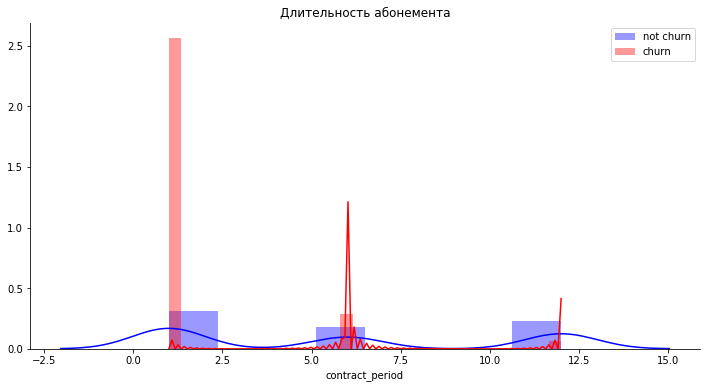

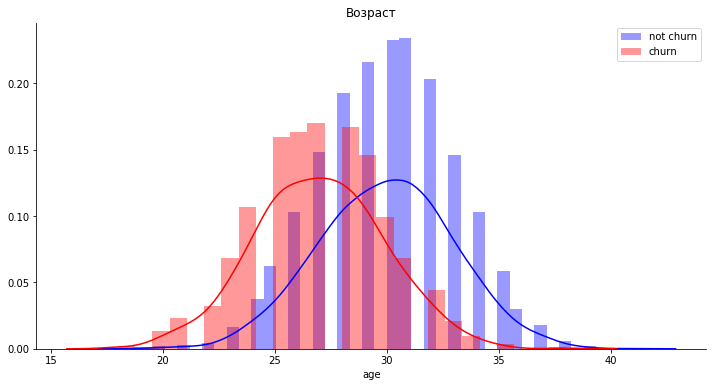

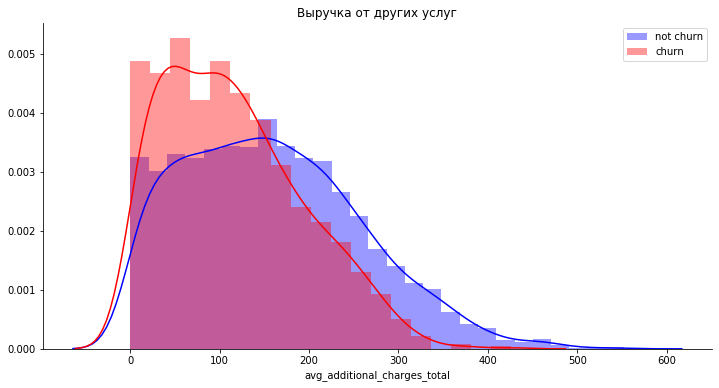

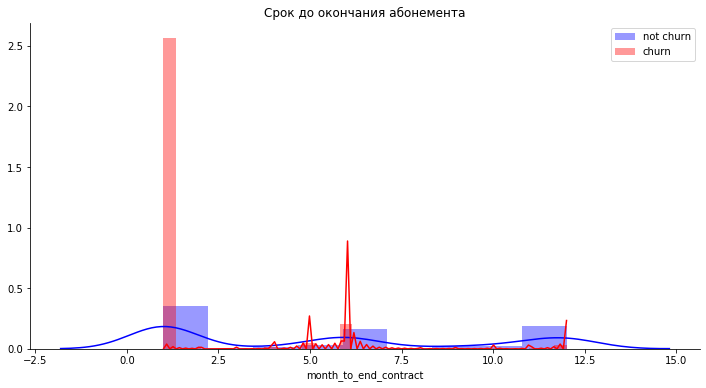

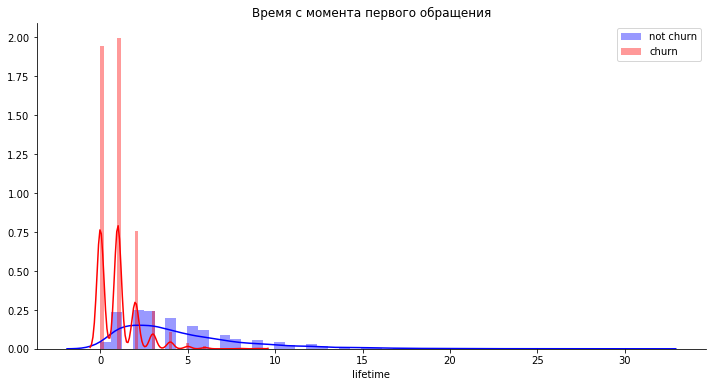

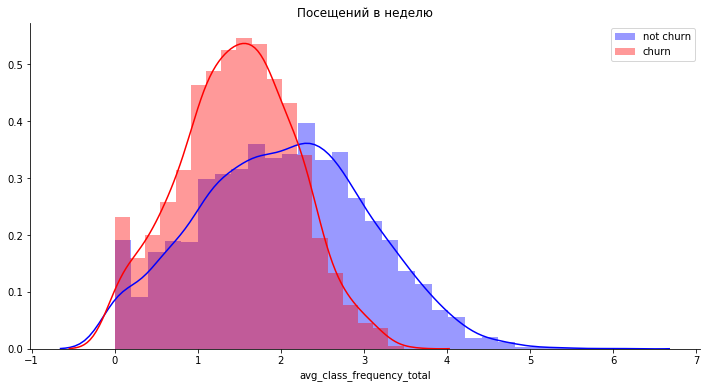

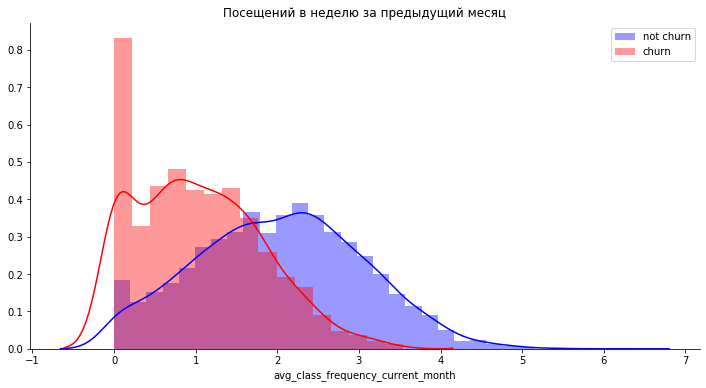

In [11]:
for i in range(len(numeric_features)):
    plt.figure(figsize=(12,6))
    plt.title(numeric_names[i])
    sns.distplot(data.loc[data['churn']==0, numeric_features[i]],
                                   color='blue', label='not churn')
    sns.distplot(data.loc[data['churn']==1, numeric_features[i]],
                                   color='red', label='churn')
    plt.legend()
    

Посмотрим на соотношение бинарных признаков:

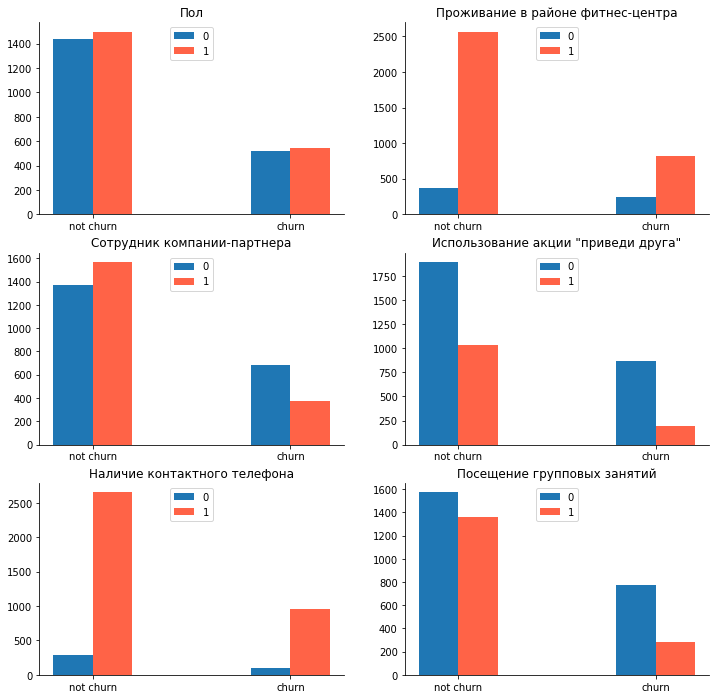

In [12]:
fig, axes = plt.subplots(3,2, figsize=(12,12))

for i in range(len(binary_features)):
    df1 = data.loc[data[binary_features[i]]==0, 'churn'].value_counts().sort_index()
    df2 = data.loc[data[binary_features[i]]==1, 'churn'].value_counts().sort_index()
    x_pos1 = [0,1]
    x_pos2 = [0.2, 1.2]
    axes[i//2, i%2].bar(x_pos1, df1.values, label='0', width=0.2)
    axes[i//2, i%2].bar(x_pos2, df2.values, color='tomato', label='1', width=0.2)
    axes[i//2, i%2].set_xticks([x+0.1 for x in x_pos1])
    axes[i//2, i%2].set_xticklabels(['not churn', 'churn'])
    axes[i//2, i%2].legend(loc='upper center')
    axes[i//2, i%2].set_title(binary_names[i]);

По графикам выше можно сделать вывод, что ушедшие клиенты в среднем:  
 - покупают абонемент на короткий срок;  
 - несколько моложе;  
 - меньше пользуются дополнительными услугами;  
 - у многих срок до окончания абонемента составляет около одного месяца;  
 - посещают клуб меньшее количество раз в неделю;
 - среди них меньше проживающих в районе фитнес-центра;
 - меньше посещают групповые занятия.

<div class="alert alert-success">
<h3> Комментарий ревьювера</h3>

Отличный анализ и эстетичные визуализации 🔥

Посмотрим на матрицу корреляций числовых признаков (поскольку для бинарных признаков корреляция Пирсона не имеет смысла, считаем только для числовых).

In [13]:
cm = data[numeric_features].corr()

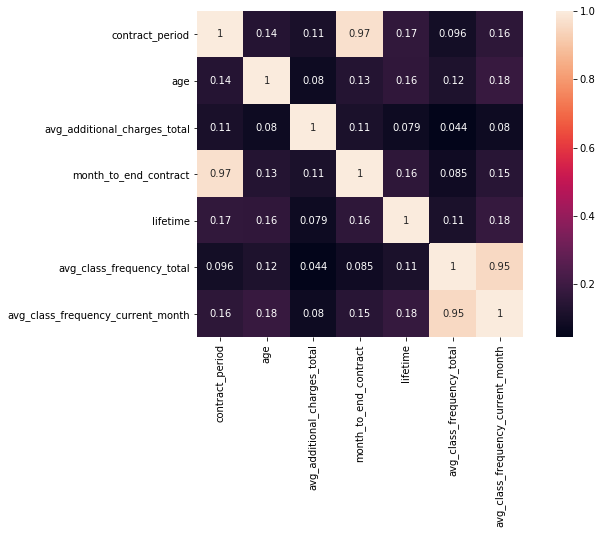

In [14]:
sns.heatmap(cm, annot=True, square=True);

Очень сильно скоррелированы пары признаков:  
- срок абонемента - количество месяцев до окончания действующего абонемента;
- количество посещений в неделю - количество посещений в неделю в текущем месяце.

<div class="alert alert-success">
<h3> Комментарий ревьювера</h3>

Все верно! Здорово, что ты решила проблему мультиколлинеарности ниже 👍🏻 

<a id='step3'></a>
## 3. Построение модели прогнозирования оттока клиентов

In [15]:
y = data['churn']
X = data.drop('churn', axis=1)

Посмотрим на сбалансированность классов.

In [16]:
y.value_counts()

0    2939
1    1061
Name: churn, dtype: int64

Лояльных клиентов в выборке почти в три раза больше.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

<div class="alert alert-warning">
<h3>Комментарий ревьюера</h3>

Можно использовать параметр stratify = y в функции train_test_split( ), где y – соответствующая целевая переменная. Данные разделятся на два кластера (наблюдения класса 0 и наблюдения класса 1), и в валидационную выборку попадут по 20% наблюдений из каждого кластера:
    
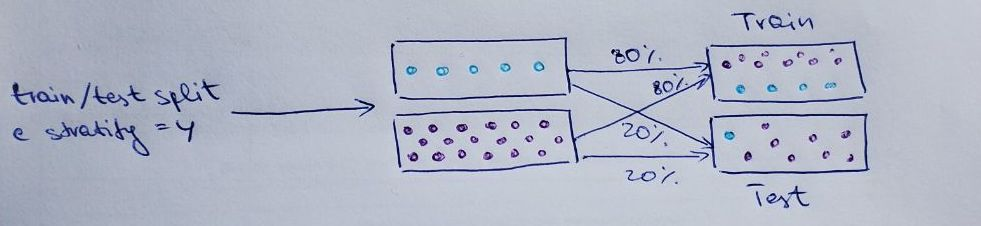
    
То есть, если соотношение классов в оригинальной выборке было 2:5, то в обучающей и валидационной выборках оно сохранится таким же. Такой подход в чем-то решает проблему несбалансированных классов.

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Комментарий студента:</b> Добавила stratify в функцию разделения выборки.</div>

Обучим модель логистической регрессией.

Избавимся от сильно скоррелированных признаков и стандартизируем остальные.

In [18]:
X_train = X_train.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis=1)
X_test = X_test.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis=1)

In [19]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [20]:
lreg = LogisticRegression()

In [21]:
lreg.fit(X_train_st, y_train)
lr_preds = lreg.predict(X_test_st)

Создаем табличку для сравнения метрик:

In [22]:
metrics = pd.DataFrame(index = ['Logistic Regression', 'Random Forest'],
                      columns = ['Accuracy', 'Precision', 'Recall'])

Обучим модель случайным лесом.

In [23]:
rforest = RandomForestClassifier(random_state=0)

In [24]:
rforest.fit(X_train_st, y_train)
rf_preds = rforest.predict(X_test_st)

In [25]:
metrics['Accuracy'] = [accuracy_score(y_test, lr_preds),
                       accuracy_score(y_test, rf_preds)]

In [26]:
metrics['Precision'] = [precision_score(y_test, lr_preds),
                        precision_score(y_test, rf_preds)]

In [27]:
metrics['Recall'] = [recall_score(y_test, lr_preds),
                     recall_score(y_test, rf_preds)]

In [28]:
metrics = metrics.round(2)
metrics

,Accuracy,Precision,Recall
Logistic Regression,0.92,0.85,0.84
Random Forest,0.89,0.84,0.73


Логистическая регрессия сработала лучше, чем случайный лес по всем метрикам. У обоих алгоритмов точность и полнота гораздо меньше, чем доля правильно определенных классов. Видимо, это объясняется тем, что в выборке почти в три раза больше оставшихся клиентов, чем ушедших. 

<div class="alert alert-success">
<h3> Комментарий ревьювера</h3>

Этап выполнен абсолютно корректно! Молодец!

<a id='step4'></a>
## 4.  Кластеризация клиентов

In [29]:
scaler = StandardScaler()
X_st = scaler.fit_transform(X)

In [30]:
linked = linkage(X_st, method='ward')

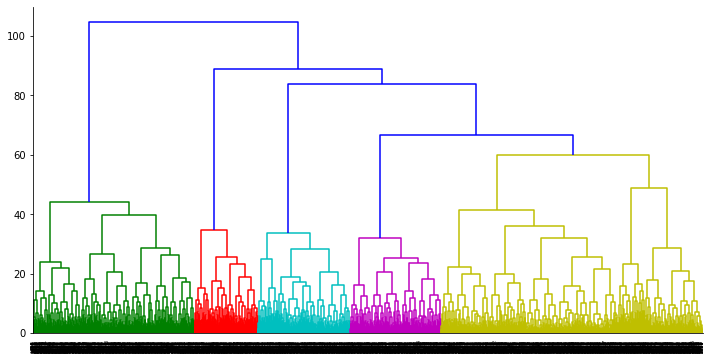

In [31]:
dendrogram(linked, orientation='top', color_threshold=60);

Судя по дендрограмме, данные хорошо делятся на 5 кластеров.

<div class="alert alert-danger">
<h3> Комментарий ревьювера</h3>
    
Необходимо указать random_state, иначе при перезапуске кода деление на кластеры все время будет разным. Поправь, пожалуйста, и проанализируй изменения :)

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Комментарий студента:</b> Исправлено. Добавила random_state и отредактировала выводы. </div>

<div class="alert alert-success">
<h3> Комментарий ревьювера v2</h3>
    
 Отлично, теперь все верно!

In [32]:
km = KMeans(n_clusters=5, random_state=0)

In [33]:
labels = km.fit_predict(X_st)

In [34]:
data['cluster'] = labels

Посмотрим на средние значения признаков для кластеров.

In [35]:
clusters_means = data.groupby('cluster').mean()
clusters_means

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.502473,0.959446,0.783383,0.574679,1.000000,10.884273,0.543027,29.980218,160.706969,9.950544,4.738872,1.983305,1.976225,0.027695
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.560335,0.976105,0.356033,0.229391,0.998805,2.665472,0.473118,30.127838,161.724258,2.455197,4.896057,2.851531,2.849473,0.068100


Посмотрим на распределения признаков для кластеров.

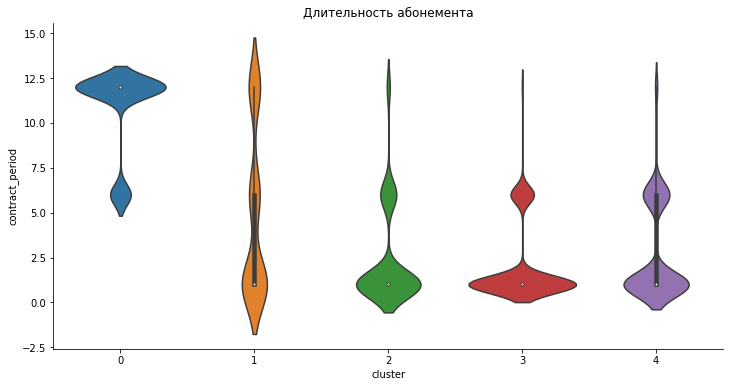

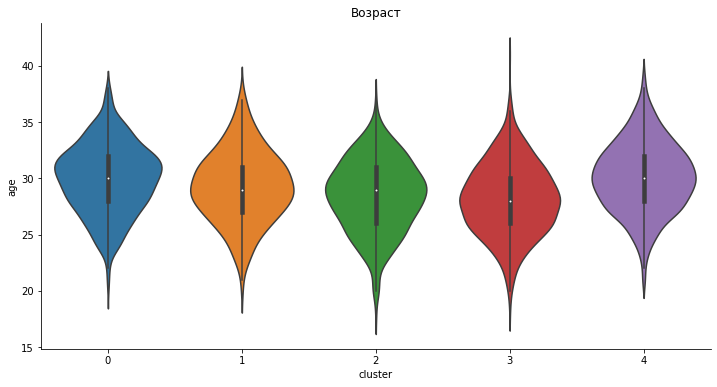

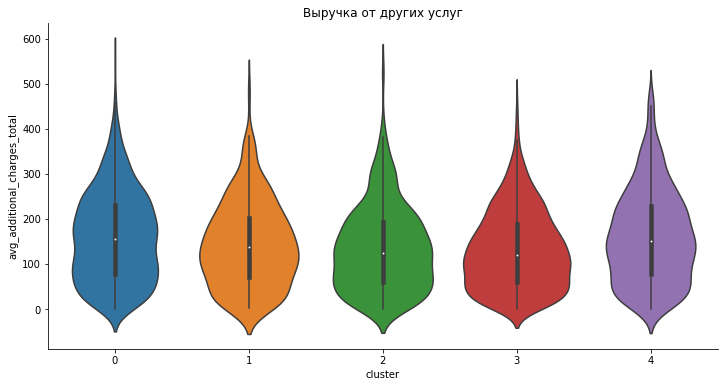

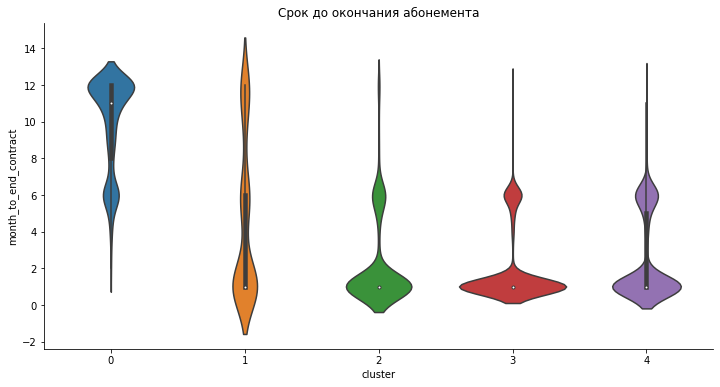

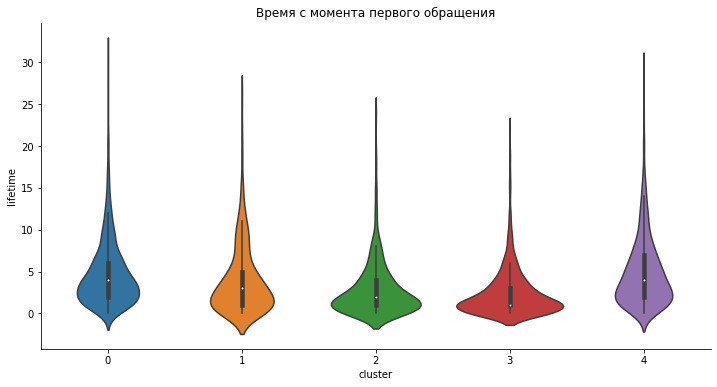

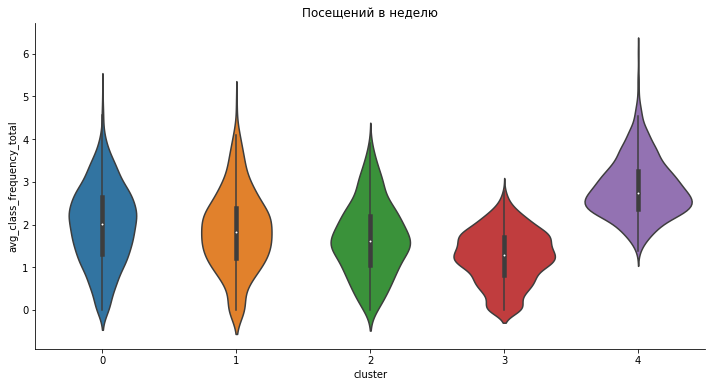

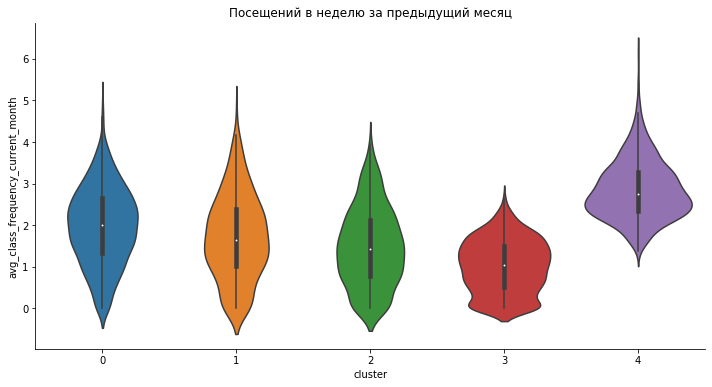

In [36]:
for i in range(len(numeric_features)):
    plt.figure()
    plt.title(numeric_names[i])
    sns.violinplot(x='cluster', y=numeric_features[i], data=data)

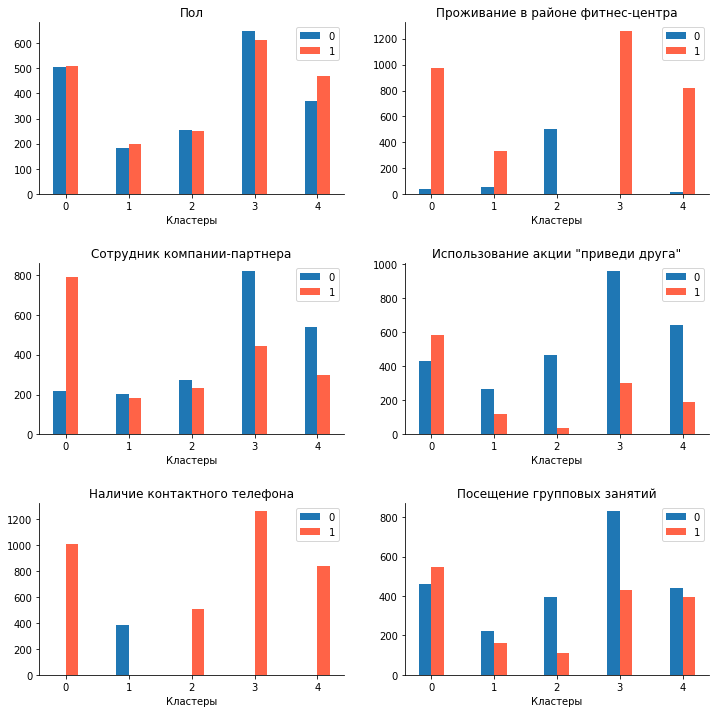

In [37]:
fig, axes = plt.subplots(3,2, figsize=(12,12))
plt.subplots_adjust(hspace=0.4)
for i in range(len(binary_features)):
    df1 = pd.DataFrame(index=range(5), data=data.loc[
        data[binary_features[i]]==0, 'cluster'].value_counts().sort_index()).fillna(0)
    df2 = pd.DataFrame(index=range(5), data=data.loc[
        data[binary_features[i]]==1, 'cluster'].value_counts().sort_index()).fillna(0)
    x_pos1 = [x for x in range(5)]
    x_pos2 = [x+0.2 for x in x_pos1]
    axes[i//2, i%2].bar(x_pos1, df1['cluster'], label='0', width=0.2)
    axes[i//2, i%2].bar(x_pos2, df2['cluster'], color='tomato', label='1', width=0.2)
    axes[i//2, i%2].set_xticks([x+0.1 for x in x_pos1])
    axes[i//2, i%2].set_xticklabels([x for x in range(5)])
    axes[i//2, i%2].legend(loc='best')
    axes[i//2, i%2].set_xlabel('Кластеры')
    axes[i//2, i%2].set_title(binary_names[i]);

Изучив средние значения и распределения признаков для разных кластеров, можно сделать следующие выводы:  
Кластер 0:  
 - приобрели абонемент на более длительный срок;  
 - имеют больший срок до окончания абонемента;
 
Кластер 1:  
 
 - не оставляют контактный телефон;
 
Кластер 2:  
 - живут не в районе фитнес-центра;  
 - меньше других использовали акцию "приведи друга";  
 
Кластер 3:  
  
 - реже посещают клуб;  
 - живут в районе клуба.
 
Кластер 4:  
 
 - чаще посещают клуб;


Посмотрим на долю оттока в разных кластерах.

In [38]:
clusters_means['churn'].sort_values(ascending=False)

cluster
3    0.514263
2    0.443564
1    0.267532
4    0.068100
0    0.027695
Name: churn, dtype: float64

Наиболее склонен к оттоку третий кластер, в нулевом собраны самые лояльные клиенты.

<a id='step5'></a>
## 5. Общий вывод

Для прогнозирования оттока были использованы логистическая регрессия и случайный лес.  
Логистическая регрессия в данном случае показывает лучшее качество классификации.  

Методом К Средних клиенты были разделены на 5 кластеров (количество кластеров было определено в результате изучения дендрограммы).

Для стратегии взаимодействия с клиентами и их удержания можно предложить следующие рекомендации:
- Самые лояльные клиенты - в кластере 0. Возможно, следует стимулировать клиентов к покупке абонементов на более длительный срок - скидки, акции.
- Наиболее склонны к оттоку кластеры 3 и 2: в них больше доля тех, кто не посещает групповые занятия. Возможно, здесь есть какая-то проблема. Стоит изучить удобство расписания и разнообразие занятий.  
- Кластер 1 имеет довольно существенную долю оттока и выделяется тем, что клиенты не оставляют контактный телефон. Можно порекомендовать собирать также и другую контактную информацию и поддерживать связь с клиентами, например, дополнительно по почте и в соцсетях.  


[К содержанию](#Содержание)

<div style="border:solid black 2px; padding: 20px">
<h3>Чек-лист доработок</h3>

По проекту видно, что ты старалась и вложила много времени и сил в проект! Он уже 🔥, но мы его сделаем прям 🔥🔥🔥

Прошу тебя:
1. **Доработать этап кластеризации.**

Жду твой проект на повторное ревью, осталось совсем чуть-чуть. Не стесняйся оставлять комментарии и задавать вопросы. Удачи! Все получится 🙂